**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Explainable Boosting Machine (EBM)

We import the libraries and define constants and settings of the notebook:

In [1]:
import pandas as pd
import numpy as np
import json
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
from scipy.stats import rankdata
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import pickle
import os, sys
sys.path.append(os.path.abspath('../TASK_3/'))
from classification_utils import *
from explanation_utils import *
RESULTS_DIR = '../data/classification_results'
RANDOM_STATE = 42
clf_name = 'ExplainableBoostingMachineClassifier'

We load the data:

In [2]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_rule_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use:

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day', 'day_of_week', 'month', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 31


In [4]:
feature_types = []
for feature in features_for_clf:
    if feature in ['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'days_from_first_incident', 'poverty_perc']:
        feature_types.append('continuous')
    elif feature in ['day', 'day_of_week', 'month', 'year', 'gun_law_rank']:
        feature_types.append('ordinal')
    else:
        feature_types.append('nominal')

In [5]:
params = {
    'feature_names' : features_for_clf,
    'feature_types': feature_types,
    'max_bins': 256,
    'max_interaction_bins': 32,
    'interactions': 10,
    'exclude': [],
    'validation_size': 0.15,
    'outer_bags': 8,
    'inner_bags': 0,
    'learning_rate': 0.01,
    'greediness': 0.0,
    'smoothing_rounds': 0,
    'max_rounds': 5000,
    'early_stopping_rounds': 50,
    'early_stopping_tolerance': 0.0001,
    'min_samples_leaf': 2,
    'max_leaves': 3,
    'objective': 'log_loss',
    'n_jobs': - 2, 
    'random_state': 42
}

ebm = ExplainableBoostingClassifier(**params)

# fit the model on all the training data
fit_start = time()
ebm.fit(indicators_train_df, true_labels_train)
fit_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_train = ebm.predict(indicators_train_df)
train_score_time = time()-train_score_start
pred_probas_train = ebm.predict_proba(indicators_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_test = ebm.predict(indicators_test_df)
test_score_time = time()-test_score_start
pred_probas_test = ebm.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=ebm, file=file)
file.close()

We display traning and test scores:

In [6]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
ExplainableBoostingMachineClassifier,0.778775,0.903852,0.836665,0.690116,0.454729,0.548224,0.734445,0.679291,0.692444,0.750392,0.760073,0.744325,0.760073,0.804243,20.341724,0.039809,"{'feature_names': ['location_imp', 'x', 'y', '..."


In [7]:
ebm_test_scores_df = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)
xgb_test_scores_df = pd.read_csv(f'{RESULTS_DIR}/ExtremeGradientBoostingClassifier_test_scores.csv', index_col=0)
pd.concat([ebm_test_scores_df, xgb_test_scores_df])

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
ExplainableBoostingMachineClassifier,0.773915,0.903202,0.833575,0.681373,0.439625,0.534432,0.727644,0.671414,0.684004,0.744290,0.754801,0.737813,0.754801,0.79877,20.341724,0.020119,"{'feature_names': ['location_imp', 'x', 'y', '..."
ExtremeGradientBoostingClassifier,0.851563,0.734608,0.788774,0.563640,0.728047,0.635381,0.707602,0.731328,0.712077,0.759393,0.732508,0.739669,0.732508,0.81588,1.864253,0.011735,"{'colsample_bylevel': 1, 'colsample_bynode': 1..."


We display confusion matrices:

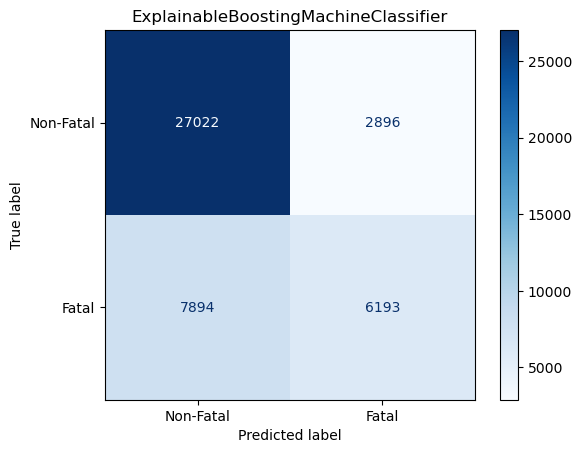

In [8]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name
)

We plot the ROC curve:

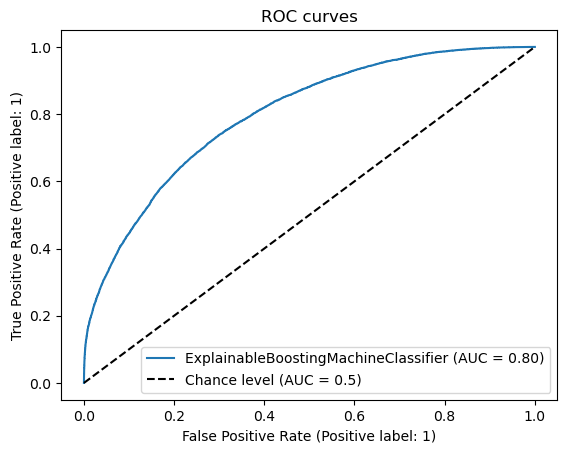

In [9]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_test[:,1]], names=[clf_name])

We plot the distribution of the features for misclassified incidents:

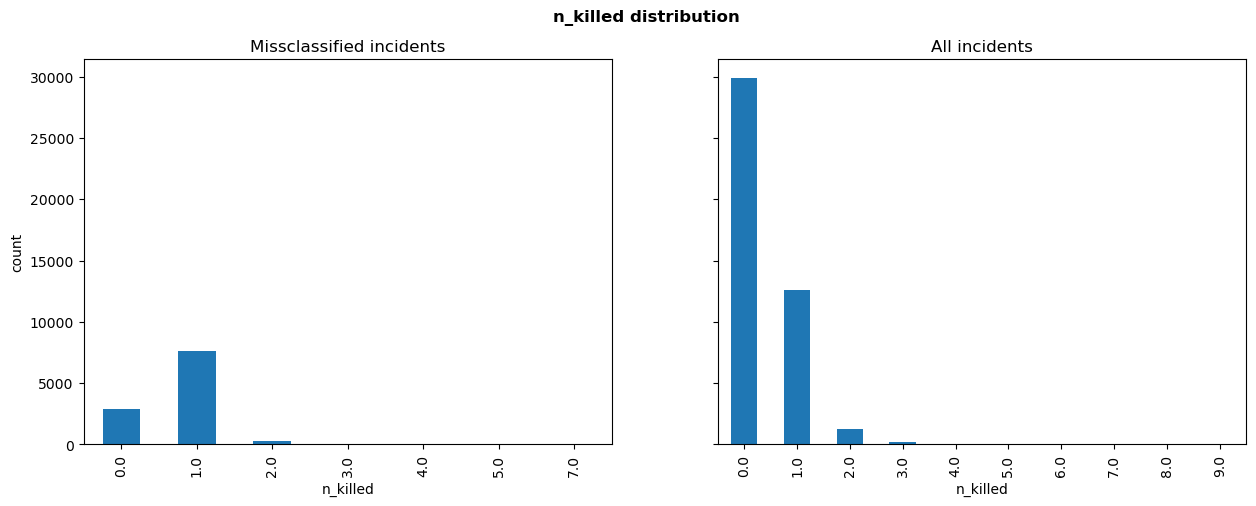

In [10]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

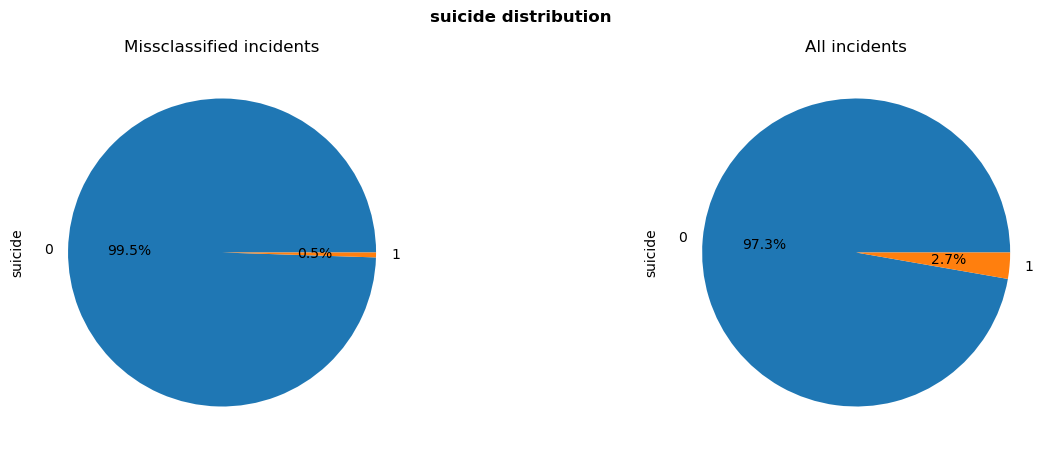

In [11]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

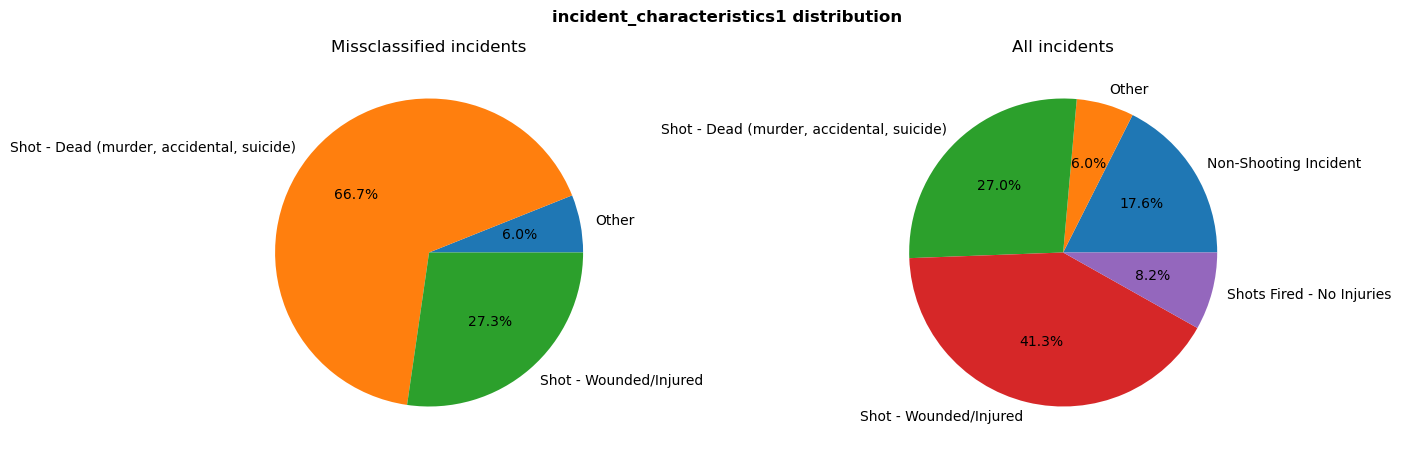

In [12]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie',
    title='incident_characteristics1 distribution'
)

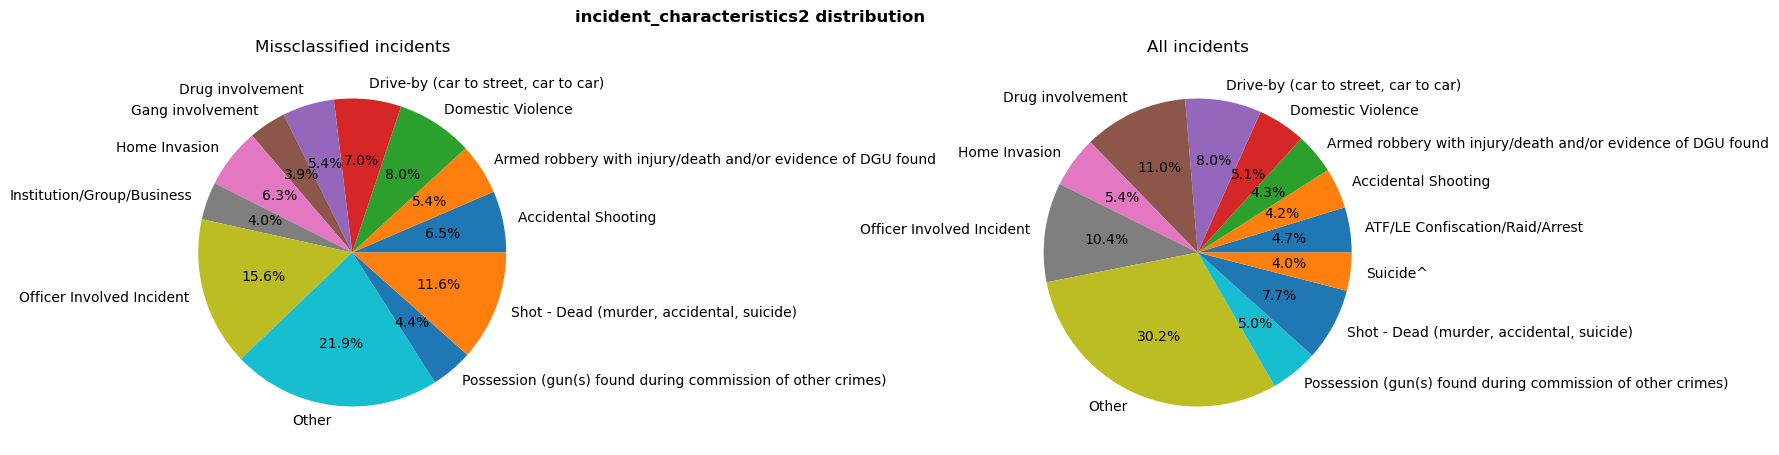

In [13]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='incident_characteristics2 distribution'
)

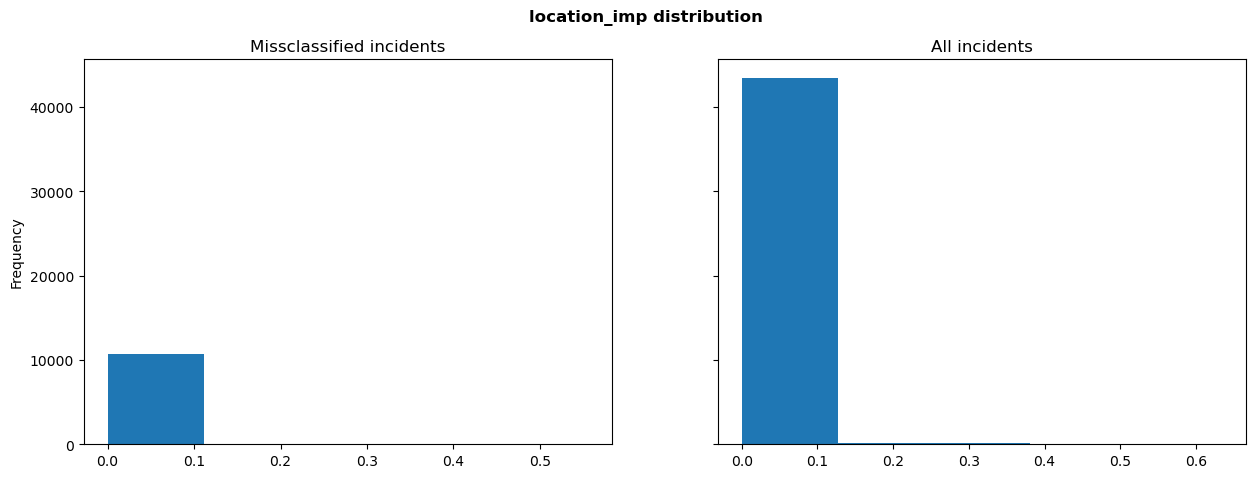

In [14]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)

## Global Interpretation

In [15]:
ebm_global = ebm.explain_global(name='EBM Global')
show(ebm_global)

<!-- http://127.0.0.1:7001/12055009040/ -->

In [16]:
# save feature importance in csv
feature_names = ebm_global.data()['names']
feature_importances = ebm_global.data()['scores']
sorted_idx = np.flip(np.argsort(feature_importances))
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_feature_imp = [feature_importances[i] for i in sorted_idx]
pd.DataFrame({
    'features': sorted_feature_names,
    'importances': sorted_feature_imp,
    'rank': rankdata([-imp for imp in sorted_feature_imp], method='dense')
}).to_csv(f'{RESULTS_DIR}/{clf_name}_feature_importances.csv')

## Local Interpretation

In [17]:
selected_records_to_explain_df = pd.read_csv('../data/explanation_results/selected_records_to_explain.csv', index_col=0)
attempted_suicide_pos = selected_records_to_explain_df[selected_records_to_explain_df['instance names']=='Attempted Suicide']['positions'][0]

In [18]:
ebm_local = ebm.explain_local(
    indicators_test_df.iloc[attempted_suicide_pos].to_frame().T,
    true_labels_test[attempted_suicide_pos].reshape(1, -1)
)
show(ebm_local)

<!-- http://127.0.0.1:7001/13015136528/ -->

In [19]:
mass_shooting_pos = selected_records_to_explain_df[selected_records_to_explain_df['instance names']=='Mass shooting']['positions']

In [20]:
ebm_local = ebm.explain_local(
    indicators_test_df.iloc[mass_shooting_pos],
    true_labels_test[mass_shooting_pos].reshape(1, -1)
)
show(ebm_local)

<!-- http://127.0.0.1:7001/12980705232/ -->

# Evaluation

In [21]:
non_fatal_rb_default = pd.read_csv(RESULTS_DIR+'/non_fatal_rb_default_features.csv').to_numpy()[0]
fatal_rb_default = pd.read_csv(RESULTS_DIR+'/fatal_rb_default_features.csv').to_numpy()[0]

In [22]:
positions_to_explain = selected_records_to_explain_df['positions'].to_list()
instance_names_to_explain = selected_records_to_explain_df['instance names'].to_list()
true_labels_to_explain = selected_records_to_explain_df['true labels'].to_list()

instances = indicators_test_df.iloc[positions_to_explain].values
metrics_selected_records = {}
for i in range(instances.shape[0]):
    prediction = ebm.predict(instances[i].reshape(1,-1))
    explanation = ebm.explain_local(instances[i], true_labels_test[i].reshape(1, -1))
    feature_importances = np.array(explanation._internal_obj['specific'][0]['scores'][:-10])
    feature_default = non_fatal_rb_default if true_labels_test[i] == 1 else fatal_rb_default
    sample_metric = evaluate_explanation(ebm, instances[i], feature_importances, feature_default)
    metrics_selected_records[instance_names_to_explain[i]] = sample_metric

metrics_selected_records_df = pd.DataFrame(metrics_selected_records).T
metrics_selected_records_df.to_csv('../data/explanation_results/ebm_metrics_selected_records.csv')
metrics_selected_records_df

,faithfulness,monotonicity
Attempted Suicide,-0.144594,False
Mass shooting,-0.906003,False
Fatal with highest confidence by DecisionTreeClassifier,-0.43341,False
Fatal with highest confidence by NeuralNetworkClassifier,-0.935448,False
Fatal with highest confidence by RandomForestClassifier,0.851045,False
Fatal with highest confidence by NaiveBayesMixedClassifier,-0.651944,False
Fatal with highest confidence by SupportVectorMachineClassifier,-0.251888,False
Fatal with highest confidence by TabNetClassifier,0.791907,False
Fatal with highest confidence by ExtremeGradientBoostingClassifier,0.76084,False
Non-Fatal with highest confidence by DecisionTreeClassifier,-0.50291,True


In [23]:
random_records_to_explain_df = pd.read_csv('../data/explanation_results/random_records_to_explain.csv', index_col=0)
positions_to_explain = random_records_to_explain_df['positions'].to_list()
true_labels_to_explain = random_records_to_explain_df['true labels'].to_list()

instances = indicators_test_df.iloc[positions_to_explain].values
faithfulness = []
for i in range(instances.shape[0]):
    prediction = ebm.predict(instances[i].reshape(1,-1))
    explanation = ebm.explain_local(instances[i], true_labels_test[i].reshape(1, -1))
    feature_importances = np.array(explanation._internal_obj['specific'][0]['scores'][:-10])
    feature_default = non_fatal_rb_default if true_labels_test[i] == 1 else fatal_rb_default
    sample_metric = evaluate_explanation(ebm, instances[i], feature_importances, feature_default)
    faithfulness.append(sample_metric['faithfulness'])

metrics_random_records = {}
metrics_random_records['mean faithfulness'] = np.nanmean(faithfulness)
metrics_random_records['std faithfulness'] = np.nanstd(faithfulness)
metrics_random_records_df = pd.DataFrame(metrics_random_records, index=[clf_name])
metrics_random_records_df.to_csv('../data/explanation_results/ebm_metrics_random_records.csv')
metrics_random_records_df

,mean faithfulness,std faithfulness
ExplainableBoostingMachineClassifier,-0.528416,0.379761
